# Topic Modeling Method 2 - Non-Negative Matrix Factorization (NMF)

Unlike LDA, which is a probablistic model, NMF is based on linear algebra algorithms and it reduces the dimension of the input corpora. It uses factor analysis method to provide comparatively less weightage to the words with less coherence. 

In NMF, **a document-word matrix V** is factorized by dimensionality into **two matrices** – a basis vectors matrix W and a coefficient matrix H, where V≈W*H and none of the matrices has negative elements. For example, in text-mining, assuming that V contains m rows (words) and n columns (documents) (i.e., n documents indexed by m words). If we want to extract r features (topics) from V, we will first factorize V into a basis vector matrix W with m rows and r columns, where W contains all the topics discovered from the documents based on the words. Then we create a coefficient matrix H with r rows and n columns, which contains the fractional combination of basis vectors and weights of each topic in the documents, so that the product of W and H will approximate to the original samples in V as much as possible (Lopes & Ribeiro, 2015). 

<img alt="" class="ce la lb c" width="400" height="100" loading="lazy" role="presentation" src="https://miro.medium.com/max/800/0*uz3OkHMgjAH2Yc40.png">

>V: the term document matrix, where V≈W*H

>H: each row of matrix H is a word embedding 

**Bag-of-words**

You may be familiar with the bag-of-words model from the Vector section. This model transforms each document to a fixed-length vector of integers. For example, given the sentences:

`John likes to watch movies. Mary likes movies too.`

`John also likes to watch football games. Mary hates football.`

The model outputs the vectors:

`[1, 2, 1, 1, 2, 1, 1, 0, 0, 0, 0]`

`[1, 1, 1, 1, 0, 1, 0, 1, 2, 1, 1]`

>W: each column of the matrix W represent the weightage of each word get in each sentences (semantic relation of words with each sentence). 

Now let us look at the mechanism in our case. Suppose we have a dataset consisting of reviews of superhero movies. In the document term matrix (input matrix), we have individual documents along the rows of the matrix and each unique term along the columns. In case, the review consists of texts like Tony Stark, Ironman, Mark 42 among others. It may be grouped under the topic Ironman. In this method, each of the individual words in the document term matrix are taken into account. While factorizing, each of the words are given a weightage based on the semantic relationship between the words. But the one with highest weight is considered as the topic for a set of words. So this process is a weighted sum of different words present in the documents.


Read the full paper:https://proceedings.neurips.cc/paper/2000/file/f9d1152547c0bde01830b7e8bd60024c-Paper.pdf

Referece & source: https://medium.com/voice-tech-podcast/topic-modelling-using-nmf-2f510d962b6e

In [2]:
import numpy as np
import pandas as pd
import re

from nltk.tag import pos_tag
from nltk.tokenize import word_tokenize

In [29]:
hurricane = pd.read_csv("hurricane_ian.csv", header = 0)
hurricane.head()

userName      screenName  \
0                        Convenience Store News.     CStoreNews_   
1                            Andrea Smith 🌊🐝🐶🐱🌱💙      dogparkgal   
2                             Sicilian-ShaSha 🇺🇸       shash1960   
3  Villain Character Development 🔜 Confuror 2022    KingOfFoxxes   
4                                   James Cooper  stratosphere53   

                userID             userLocation  \
0            156666863                     ORD    
1  1509146276461531137             Florida, USA   
2  1220870146039975936                      NaN   
3  1054890619867410433  Baja California, México   
4             50626909                  Atlanta   

                                                                                                                                                    user_descrip  \
0  Top Convenience Retail Influencer Millions of Views Marketing Data Data Grocery Food Service Data Gas Pricing Data Beverage Data Tobacco Data. DM For Removal   
1                                                     Starting over after a hack. Was @dogparkgoddess Democracy will prevail. The GQP is trash, arrest them all.   
2                                                                                                                         American/Italian 🇺🇸🇮🇹 #MAGAAMERICAN 🇺🇸   
3                           | 21 Y.O | Mexican 🇲🇽 | Coffe Boi ☕️ | ♣️ Life is a Gamble ♦️ | Any pronouns | DM Open! | Vent Account: @AngryCheeseBoy | Myosotis 🌸   
4    Air Force Brat /  Vietnam veteran  /  Customer service in Insurance and Air conditioning  /  Cisco Networking student /  sixty-one years old but look forty   

                 user_url  followers  friends                 user_ctime  \
0                     NaN      43224    47652  2010-06-17 15:20:29+00:00   
1                     NaN       2456     3467  2022-03-30 12:31:39+00:00   
2                     NaN        307      333  2020-01-25 00:45:06+00:00   
3                     NaN        270     1186  2018-10-24 00:21:37+00:00   
4  http://t.co/5gcImzgdlS        229      582  2009-06-25 12:06:55+00:00   

                source                  post_time             tweet_id  \
0   Twitter for iPhone  2022-09-26 23:59:59+00:00  1574549376025755648   
1  Twitter for Android  2022-09-26 23:59:58+00:00  1574549371961544704   
2   Twitter for iPhone  2022-09-26 23:59:56+00:00  1574549362314723331   
3  Twitter for Android  2022-09-26 23:59:54+00:00  1574549355977023488   
4      Twitter Web App  2022-09-26 23:59:54+00:00  1574549355176001542   

                                                                                                                                                                                                                                                                                                    tweet_text  \
0                                                                                                                                                                                                                                                               Get lost Hurricane Ian https://t.co/xsY8JlKe8h   
1                                                                                                                                                                                                                                             @SunnyPete6760 Wish us well during Hurricane Ian! \nHey buddy! 😊   
2  Stressed about Hurricane Ian,seriously don’t want to leave my home to evacuate, but will have no choice. Tomorrow I know I’ll get the order, Zone B. I evacuated for Irma, much has change for me in 5 yrs, seems overwhelming now. One thing, I’m blessed to have family to go to. https://t.co/cVfqjszxJN   
3                                                                                                                                                                 RT @_chaibear: ppl really telling me to "be careful

In [30]:
# display the full text information
pd.set_option('display.max_colwidth', None)
# remove the emojis from the tweets
hurricane['tweet_text'] = hurricane['tweet_text'].apply(lambda x: x.encode('ascii', 'ignore').decode('ascii'))
# make the name simplier
tweets = hurricane['tweet_text']
# remove the links from tweets
tweets = tweets.apply(lambda x: re.split('https:\/\/.*', str(x))[0])
tweets.head(2)

0                                            Get lost Hurricane Ian 
1    @SunnyPete6760 Wish us well during Hurricane Ian! \nHey buddy! 
Name: tweet_text, dtype: object

In [4]:
# use all the nouns
def nouns(text):
    '''Given a string of text, tokenize the text and pull out only the nouns.'''
    is_noun = lambda pos: pos[:2] == 'NN'
    tokenized = word_tokenize(text)
    all_nouns = [word for (word, pos) in pos_tag(tokenized) if is_noun(pos)] 
    return ' '.join(all_nouns)

In [5]:
# apply it to the tweets
tweets_nouns = tweets.apply(nouns)
tweets_nouns.head()

0                                                                           Hurricane Ian
1                                                  @ SunnyPete6760 Wish Hurricane Ian Hey
2    Hurricane Ian home choice Tomorrow Ill order Zone B. Irma change yrs thing Im family
3                                       RT ppl hurricane ian hundreds hours disaster surv
4          RT @ stratosphere53 Canada damage Fiona Cuba Florida brace storm Ian Breitbart
Name: tweet_text, dtype: object

In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from sklearn.feature_extraction import text

add_stop_words = ['hurricane','ian','rt']
stop_words = text.ENGLISH_STOP_WORDS.union(add_stop_words)

In [32]:
# use TFIDF to create a Vectorizer
vectorizer1 = TfidfVectorizer(stop_words=stop_words)
vec1 = vectorizer1.fit_transform(tweets_nouns)
tfidf_feature_names = vectorizer1.get_feature_names()

# Run NMF
# for hyperparameter tuning: documentation: https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.NMF.html
nmf1 = NMF(n_components=10, random_state=0)

NMFmodel1 = nmf1.fit(vec1)

NameError: name 'tweets_nouns' is not defined

In [8]:
# use the function we wrote in Challenge Lab 16
def display_topics(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic %d:" % (topic_idx + 1)) 
        print(" ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]])) 

In [9]:
#set the number of top words display
nmf_topics = display_topics(NMFmodel1, tfidf_feature_names, n_top_words=15)
print(nmf_topics)

Topic 1:
president occupydemocrats resources politics trump biden breaking proud youre sharpie just nothoodlum mar lago white
Topic 2:
karla landf thoughts prayers family people cuba charliecrist tomaskenn rainfall miami lauraadderley presenters impacts gulf
Topic 3:
boo course therecount uh golf gov floridas fl ron impacts gulf coast desantis namwella1961 delivers
Topic 4:
request nousefortrump joe funds emergency florida biden disaster state orangecofl governor preparation ocflmayor smosh ironik0422
Topic 5:
governor vineyard marthas desantis doc_chimpanzee breaking disaster florida ron thehill white response house sundaedivine citizens
Topic 6:
storm surge warnings category govrondesantis coast watches strength winds nhc_surge florida nhc_atlantic messages key wes
Topic 7:
track tropicalupdate nhc latest new satellite look afternoon coast center newsmax warnings floridas update national
Topic 8:
news nasa artemis sls lorengrush lauraadderley presenters impacts rocket cuba atnoon peo

### Results we got from LDA from chanllenge lab #16

Topic 1:
tuesday week buccaneers tampa afternoon looming adamschefter school hey officials monday vengolor ther staying friday

Topic 2:
florida emergency funds joe biden nousefortrump request amp floridians state ians hurricanes fl st weather

Topic 3:
florida disaster governor world disney walt mar lago doggintrump dear repeat caribbean georgia intensifying stuostro

Topic 4:
way path advisory rain florida night intermediate landfall powers friday weaken week eye kirstiealley makeianweak

Topic 5:
course boo florida authorities plan charliecrist house response white desantis thehill politics dailycaller women servicemen

Topic 6:
track desantis tropicalupdate marthas vineyard governor doc_chimpanzee breaking latest nhc new satellite afternoon look state

Topic 7:
tampa bay florida gulf cuba coast area warning storm miami forecast mexico national case hurricanes

Topic 8:
trump occupydemocrats president biden politics breaking resources pinellas sarasota effect mar hillsborough mon amp counties

Topic 9:
people family cuba prayers charliecrist thoughts landf karla news nasa artemis lorengrush sls center national

Topic 10:
storm surge florida winds category warnings amp mph update risk strength coast tennessee panic middle

## NMF - Gensim

Gensim's Online Non-Negative Matrix Factorization (NMF, NNMF, ONMF) implementation is based on Renbo Zhao, Vincent Y. F. Tan: Online Nonnegative Matrix Factorization with Outliers, 2016 and is optimized for extremely large, sparse, streamed inputs. Such inputs happen in NLP with unsupervised training on massive text corpora.

source:https://notebook.community/piskvorky/gensim/docs/notebooks/nmf_tutorial

In [18]:
#create a dictionary contains all the words instead of using words' ids
from gensim import corpora
from gensim.models import Nmf
from gensim.matutils import Sparse2Corpus

dictionary = corpora.Dictionary([tfidf_feature_names]) 
corpus = Sparse2Corpus(vec1) #Convert a matrix in scipy.sparse format into a streaming gensim corpus.

# using Gensim to build NMF model
gen_nmf = Nmf(corpus=corpus, num_topics=10, id2word=dictionary) #if you don't have this parameter, it will only show the words' ids

gen_nmf.print_topics(num_words=10)

[(0,
  '0.001*"foxed" + 0.001*"45" + 0.001*"cherri" + 0.001*"lotus" + 0.001*"kardian" + 0.001*"duchy" + 0.001*"explored" + 0.001*"margarets" + 0.001*"habite" + 0.001*"cowley"'),
 (1,
  '0.001*"interspecies" + 0.001*"marvin" + 0.001*"burnish" + 0.001*"fishy" + 0.001*"aspects" + 0.001*"fordist" + 0.001*"goebells" + 0.001*"frauds" + 0.001*"jordanian" + 0.001*"detector"'),
 (2,
  '0.001*"hawas" + 0.000*"columbu" + 0.000*"howie" + 0.000*"friendliness" + 0.000*"askey" + 0.000*"cmmandments" + 0.000*"crowning" + 0.000*"euro" + 0.000*"bagginses" + 0.000*"emotions"'),
 (3,
  '0.001*"lagos" + 0.001*"kam" + 0.001*"hollinghurst" + 0.001*"mocha" + 0.001*"bladck" + 0.001*"greyhounds" + 0.001*"delirious" + 0.001*"listner" + 0.001*"convida" + 0.001*"boxed"'),
 (4,
  '0.001*"loft" + 0.001*"hem" + 0.001*"flinstones" + 0.001*"becuase" + 0.001*"cisco" + 0.001*"mclure" + 0.001*"conditioning" + 0.001*"flopsy" + 0.001*"atmos" + 0.001*"byplay"'),
 (5,
  '0.000*"brinkley" + 0.000*"lovecraft" + 0.000*"jospeh" + 

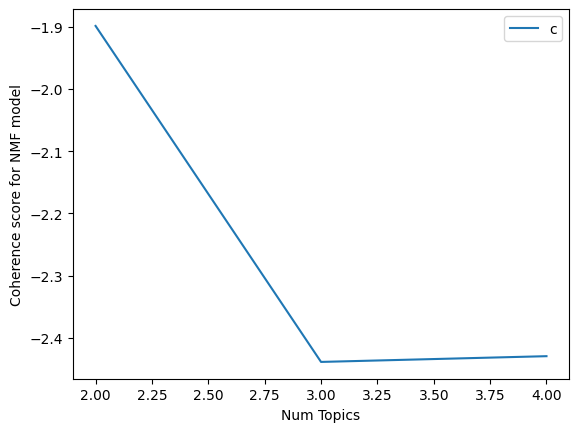

In [20]:
# try to find the best k 
from gensim.models.coherencemodel import CoherenceModel

coherence = []

for k in range(2, 5):
    good_model = Nmf(corpus=corpus, num_topics=k, id2word=dictionary, passes=25) #Number of passes through the corpus during training.
    
    good_cohe = CoherenceModel(model=good_model, corpus=corpus,
                            dictionary=dictionary, coherence='u_mass') #The greater the number, the better is coherence score.
    
    coherence.append(good_cohe.get_coherence())
    
# Show graph
import matplotlib.pyplot as plt

x = range(2,5)
plt.plot(x, coherence)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score for NMF model")
plt.legend(("coherence_values"), loc='best')
plt.show()

# State of art techniques (Semi-supervised ML)

# Topic Modeling Method 3 - Top2Vec (2020)

They define topic modeling to be the process of finding topics, as weighted sets of words, that best represent
the information of the documents.

>**How does it work**
>1. Create jointly embedded document and word vectors using Doc2Vec

**Bag-of-words**

You may be familiar with the bag-of-words model from the Vector section. This model transforms each document to a fixed-length vector of integers. For example, given the sentences:

`John likes to watch movies. Mary likes movies too.`

`John also likes to watch football games. Mary hates football.`

The model outputs the vectors:

`[1, 2, 1, 1, 2, 1, 1, 0, 0, 0, 0]`

`[1, 1, 1, 1, 0, 1, 0, 1, 2, 1, 1]`

Each vector has 10 elements, where each element counts the number of times a particular word occurred in the document. The order of elements is arbitrary. In the example above, the order of the elements corresponds to the words: `["John", "likes", "to", "watch", "movies", "Mary", "too", "also", "football", "games", "hates"]`.

***Bag-of-words models are surprisingly effective, but have several weaknesses.***

- First, they lose all information about word order: “John likes Mary” and “Mary likes John” correspond to identical vectors.
- Second, the model does not attempt to learn the meaning of the underlying words, and as a consequence, the distance between vectors doesn’t always reflect the difference in meaning.

**Word2Vec**
lower-dimensional vector space using a shallow neural network. The result is a set of word-vectors where vectors close together in vector space have similar meanings based on context, and word-vectors distant to each other have differing meanings. For example, `strong` and `powerful` would be close together and `strong` and `Paris` would be relatively far.

With the Word2Vec model, we can calculate the vectors for each word in a document. 

**Doc2Vec**

Documents will be placed close to other similar documents and close to the most distinguishing words.

<img src="https://raw.githubusercontent.com/ddangelov/Top2Vec/master/images/doc_word_embedding.svg?sanitize=true" alt="" width="600" height="whatever" style="max-width: 100%;">

>2. Perform dimensionality reduction on the vectors using an algorithm such as UMAP.

**Uniform Manifold Approximation and Projection (UMAP)**

is a dimension reduction technique that can be used for visualisation similarly to t-SNE, but also for general non-linear dimension reduction. The algorithm is founded on three assumptions about the data:

1. The data is uniformly distributed on a Riemannian manifold;
2. The Riemannian metric is locally constant (or can be approximated as such);
3. The manifold is locally connected.
4. From these assumptions it is possible to model the manifold with a fuzzy topological structure. The embedding is found by searching for a low dimensional projection of the data that has the closest possible equivalent fuzzy topological structure.

Read the full paper:https://arxiv.org/pdf/1802.03426.pdf

***Dimension reduction in text data***

Cutting the "non-important" words saves computationally expensive novel methods can construct predictive models with high accuracy from high-dimensional data.

High dimensionality reduction solves the problem of inefficient computation and increase the difficulty in detecting and exploiting the relationships among terms. After getting the relationship among the key words, clustering is done very effectively and easily. The processing time will be reduced. 

***Document vectors in high dimensional space are very sparse, dimension reduction helps for finding dense areas.***

<img src="https://raw.githubusercontent.com/ddangelov/Top2Vec/master/images/umap_docs.png" alt="" width="700" height="whatever" style="max-width: 100%;">


>3. Cluster the vectors using a clustering algorithm such as HDBSCAN.

**Hierarchical Density-Based Spatial Clustering of Applications with Noise (HDBSCAN)**

In practice this means that HDBSCAN returns a good clustering straight away with little or no parameter tuning -- and the primary parameter, minimum cluster size, is intuitive and easy to select.

***The colored areas are the dense areas of documents. Red points are outliers that do not belong to a specific cluster.***

<img src="https://raw.githubusercontent.com/ddangelov/Top2Vec/master/images/hdbscan_docs.png" alt="" width="700" height="whatever" style="max-width: 100%;">

>4. For each dense area calculate the centroid of document vectors in original dimension, this is the topic vector. Assign topics to each cluster.

***The red points are outlier documents and do not get used for calculating the topic vector. The purple points are the document vectors that belong to a dense area, from which the topic vector is calculated.***

<img src="https://raw.githubusercontent.com/ddangelov/Top2Vec/master/images/topic_vector.svg?sanitize=true" alt="" width="600" height="whatever" style="max-width: 100%;">

>5. Find n-closest word vectors to the resulting topic vector.

***The closest word vectors in order of proximity become the topic words.***

<img src="https://raw.githubusercontent.com/ddangelov/Top2Vec/master/images/topic_words.svg?sanitize=true" alt="" width="600" height="whatever" style="max-width: 100%;">

>**Advantages**
1. Automatically finds number of topics.
2. No stop word lists required.
3. No need for stemming/lemmatization.
4. Works on short text.
5. Creates jointly embedded topic, document, and word vectors.
6. Has search functions built in.

Read the full paper:https://arxiv.org/pdf/2008.09470.pdf

References & Sources:

1. https://radimrehurek.com/gensim/auto_examples/tutorials/run_doc2vec_lee.html#sphx-glr-auto-examples-tutorials-run-doc2vec-lee-py
2. https://github.com/ddangelov/Top2Vec
3. https://www.ijert.org/research/text-data-pre-processing-and-dimensionality-reduction-techniques-for-document-clustering-IJERTV1IS5278.pdf
4. UMAP https://github.com/lmcinnes/umap
5. HDBSCAN https://github.com/scikit-learn-contrib/hdbscan
6. McInnes L, Healy J. Accelerated Hierarchical Density Based Clustering In: 2017 IEEE International Conference on Data Mining Workshops (ICDMW), IEEE, pp 33-42. 2017



**Install the library:**

! pip install top2vec

https://anaconda.org/conda-forge/top2vec

***Top2Vec - the pre-trained universal sentence encoders***

! pip install top2vec[sentence_encoders]

(Alternative:! pip install tensorflow tensorflow_hub tensorflow_text)

*The Universal Sentence Encoder encodes text into high dimensional vectors that can be used for text classification, semantic similarity, clustering, and other natural language tasks. The pre-trained Universal Sentence Encoder is publicly available in Tensorflow-hub.*

source:https://towardsdatascience.com/use-cases-of-googles-universal-sentence-encoder-in-production-dd5aaab4fc15#:~:text=The%20Universal%20Sentence%20Encoder%20encodes,publicly%20available%20in%20Tensorflow%2Dhub.

In [1]:
from top2vec import Top2Vec

2022-11-08 14:31:28.154960: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


KeyboardInterrupt: 

In [33]:
# build the model using Top2Vec
# your text data should a list of string
Top_model = Top2Vec(tweets.values, embedding_model='universal-sentence-encoder') #Top2Vec - the pre-trained universal sentence encoders

ImportError: universal-sentence-encoder is not available.

Try: pip install top2vec[sentence_encoders]

Alternatively try: pip install tensorflow tensorflow_hub tensorflow_text

In [14]:
# viewing the number of topics
Top_model.get_num_topics()

20

In [15]:
#Getting Keywords for each Topic
Top_model.topic_words[:2]

array([['hurricane', 'storm', 'tampa', 'rt', 'florida', 'ian', 'surge',
        'are', 'is', 'our', 'politics', 'never', 'for', 'will', 'trump',
        'pledges', 'now', 'federal', 'cuba', 'pm', 'breaking', 'all',
        'out', 'be', 'has', 'at', 'to', 'not', 'have', 'does', 'we',
        'as', 'here', 'it', 'charliecrist', 'its', 'would', 'puts', 'on',
        'this', 'necessa', 'in', 'that', 'occupydemocrats', 'but', 'and',
        'resources', 'president', 'the', 'an'],
       ['trump', 'biden', 'politics', 'president', 'rt', 'pledges',
        'federal', 'resources', 'never', 'pm', 'all', 'aside',
        'hurricane', 'breaking', 'now', 'does', 'what', 'has', 'tampa',
        'ian', 'an', 'charliecrist', 'puts', 'not', 'necessa', 'have',
        'with', 'is', 'cuba', 'here', 'you', 'we', 'at', 'it', 'but',
        'are', 'the', 'our', 'this', 'there', 'that', 'of', 'and', 'be',
        'out', 'in', 'as', 'would', 'for', 'on']], dtype='<U15')

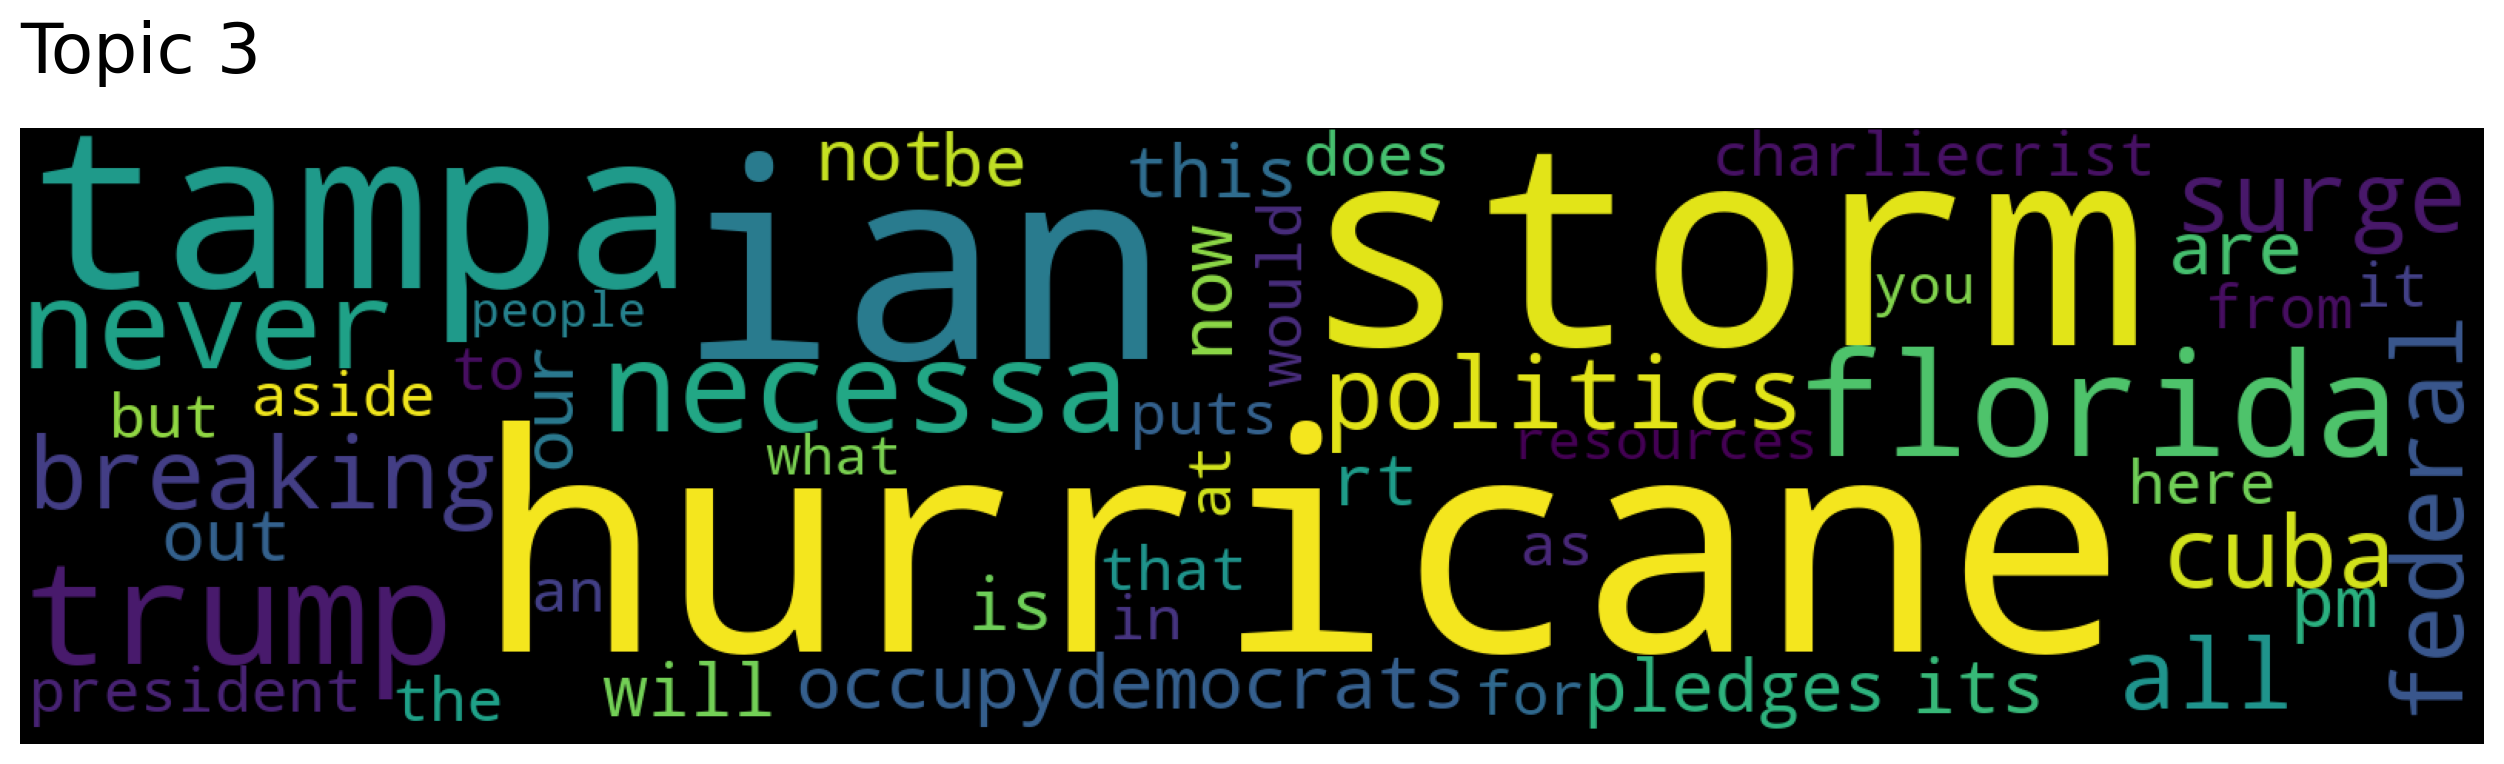

In [16]:
#Creating Topic Word Clouds for topic 4
Top_model.generate_topic_wordcloud(3)

>**Search Topics**

We are going to search for topics most similar to a given word.

Returns:

- `topic_words`: For each topic the top 50 words are returned, in order of semantic similarity to topic.
- `word_scores`: For each topic the ***cosine similarity scores*** of the top 50 words to the topic are returned.
- `topic_scores`: For each topic the cosine similarity to the search keywords will be returned.
- `topic_nums`: The unique index of every topic will be returned.

**Cosine similarity**

In data analysis, cosine similarity is a measure of similarity between two sequences of numbers.

Source:https://en.wikipedia.org/wiki/Cosine_similarity

In [17]:
#Searching for Topics Using Keywords
topic_words, word_scores, topic_scores, topic_nums = Top_model.search_topics(keywords=["storm"], num_topics=10)

print(topic_nums)
print(topic_scores)

[ 5 15  2  3  9  7 18  0  4 12]
[0.51377979 0.47524704 0.45330069 0.44497852 0.38113072 0.32558589
 0.3249335  0.32271318 0.31912378 0.31181034]


Topic 4 was the most similar topic to "storm" with a cosine similarity of 0.49720448. Also, topic 16 has high similarity scores as well.

In [18]:
# get topic 16
Top_model.topic_words[15]

array(['hurricane', 'storm', 'surge', 'tampa', 'florida', 'rt', 'trump',
       'are', 'breaking', 'never', 'now', 'federal', 'politics', 'cuba',
       'occupydemocrats', 'all', 'puts', 'ian', 'resources', 'necessa',
       'is', 'but', 'for', 'has', 'have', 'not', 'be', 'pledges', 'that',
       'this', 'our', 'will', 'it', 'president', 'to', 'we', 'as', 'at',
       'there', 'here', 'does', 'pm', 'aside', 'biden', 'its', 'in',
       'out', 'on', 'would', 'those'], dtype='<U15')

# Topic Modeling Method 4 - BERTopic (2022)

**B**idirectional **E**ncoder **R**epresentations from **T**ransformers (BERT)

It extracts coherent topic representation through the development of a **class-based variation of TF-IDF**. More specifically, BERTopic generates document embedding with **pre-trained transformer-based language models, clusters these embeddings, and
finally, generates topic representations with the class-based TF-IDF procedure**. BERTopic generates coherent topics and remains competitive across a variety of benchmarks involving classical models and those that follow the more recent clustering approach of topic modeling.

>**How does it work**
>1. Embed the textual data(documents)

By default, it uses the following sentence transformers

- "paraphrase-MiniLM-L6-v2"- This is an English BERT-based model trained specifically for semantic similarity tasks. 
- "paraphrase-multilingual-MiniLM-L12-v2"- This is similar to the first, with one major difference is that the xlm models work for 50+ languages.

>2. Cluster Documents

It uses UMAP to reduce the dimensionality of embeddings and the HDBSCAN technique to cluster reduced embeddings and create clusters of semantically similar documents.

>3. Create a topic representation

The last step is to extract and reduce topics with `class-based TF-IDF` and then improve the coherence of words with `Maximal Marginal Relevance`.

**Class-based TF-IDF**

Unlike the traditional TF-IDF, which the inverse document frequency measures how much information a term provides to a document,  `class-based TF-IDF` replaces the inverse document frequency with the inverse class frequency to measure how much information a term provides to a class. 

**Maximal Marginal Relevance**

Maximal Marginal Relevance (MMR) between candidate keywords and the document. MMR considers the similarity of keywords/keyphrases with the document, along with the similarity of already selected keywords and keyphrases. This results in a selection of keywords that maximize their within diversity with respect to the document.

Read the full paper:https://arxiv.org/pdf/2203.05794.pdf

Sources:
1. https://maartengr.github.io/BERTopic/api/mmr.html
2. https://hackernoon.com/nlp-tutorial-topic-modeling-in-python-with-bertopic-372w35l9

**Install the library:**

! pip install bertopic (it doesn't have the verson for anaconda installer yet)

In [20]:
#import packages

import pandas as pd 
import numpy as np
from bertopic import BERTopic

In [20]:
# Build the model with BERTopic
# documentation: https://maartengr.github.io/BERTopic/api/bertopic.html#bertopic._bertopic.BERTopic
BER_model = BERTopic() 

topics, probabilities = BER_model.fit_transform(tweets)

In [21]:
#Select Top 10 Topics
# in total it returns 32 topics
BER_model.get_topic_freq().head(11)

Topic  Count
0      -1    174
1       0    106
2       1     44
3       2     44
4       3     35
5       4     35
6       5     29
7       6     28
8       7     28
9       8     26
10      9     25

**Note:**  Topic -1 is the largest and it refers to outliers tweets that do not assign to any topics generated. In this case, we will ignore Topic -1. Therefore, we are querying 11 to see the top 10 topics.

In [22]:
#check the top words for each topics
BER_model.get_topic(0)

[('president', 0.0936992815127396),
 ('never', 0.09329287275434746),
 ('occupydemocrats', 0.09329287275434746),
 ('pledges', 0.09160900661139629),
 ('resources', 0.09160900661139629),
 ('politics', 0.0913255781095073),
 ('aside', 0.0913255781095073),
 ('necessa', 0.0911950355353685),
 ('does', 0.0911950355353685),
 ('federal', 0.09038123702147624)]

In [23]:
# visualize your model: intertopic distance map
BER_model.visualize_topics()

In [24]:
# visualize by terms
BER_model.visualize_barchart()

In [25]:
# visualize the topic similarty
BER_model.visualize_heatmap()

In [26]:
# Topic reduction
newBER_model = BERTopic(nr_topics=10)

new_topics, new_probabilities = newBER_model.fit_transform(tweets)

In [27]:
newBER_model.visualize_heatmap()

In [28]:
# Visualize Topic Hierarchy
newBER_model.visualize_hierarchy()

In [29]:
# visualize the term scores
newBER_model.visualize_term_rank()

**Notice：** 
1. You can use the model to test new datasets to make prediction.

USING SYNTAX: topics, probs = model.transform(new_docs)

2. You also can save this trained model for future use

USING SYNTAX: model.save("my_topics_model")

3. Load the model

USING SYNTAX: BERTopic.load("my_topics_model")

# A Topic Modeling Comparison Between LDA, NMF, Top2Vec, and BERTopic to Demystify Twitter Posts

**Abstract**

The richness of social media data has opened a new avenue for social science research to gain insights into human behaviors and experiences. In particular, emerging data-driven approaches relying on topic models provide entirely new perspectives on interpreting social phenomena. However, the short, text-heavy, and unstructured nature of social media content often leads to methodological challenges in both data collection and analysis. In order to bridge the developing field of computational science and empirical social research, this study aims to evaluate the performance of four topic modeling techniques; namely latent Dirichlet allocation (LDA), non-negative matrix factorization (NMF), Top2Vec, and BERTopic. In view of the interplay between human relations and digital media, this research takes Twitter posts as the reference point and assesses the performance of different algorithms concerning their strengths and weaknesses in a social science context. Based on certain details during the analytical procedures and on quality issues, this research sheds light on the efficacy of using BERTopic and NMF to analyze Twitter data.

Read the full paper:https://www.frontiersin.org/articles/10.3389/fsoc.2022.886498/full

# Actions: Use the 3 methods you have learned today to conduct the topic modeling with the IMDB movie data. Comparing the results from LDA, NMF, Top2Vec, and BERTopic.

In [2]:
import numpy as np
import pandas as pd
import re

from nltk.tag import pos_tag
from nltk.tokenize import word_tokenize

In [3]:
movies = pd.read_csv("IMDBDataset.csv", header = 0)
movies.head()

review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive

In [4]:
# display the full text information
pd.set_option('display.max_colwidth', None)
# remove the emojis from the tweets
movies['review'] = movies['review'].apply(lambda x: x.encode('ascii', 'ignore').decode('ascii'))
# make the name simplier
reviews = movies['review']
# remove the links from tweets
reviews = reviews.apply(lambda x: re.split('https:\/\/.*', str(x))[0])
reviews.head(2)

0    One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of the show is due to th

In [5]:
def nouns(text):
    '''Given a string of text, tokenize the text and pull out only the nouns.'''
    is_noun = lambda pos: pos[:2] == 'NN'
    tokenized = word_tokenize(text)
    all_nouns = [word for (word, pos) in pos_tag(tokenized) if is_noun(pos)] 
    return ' '.join(all_nouns)

In [6]:
# apply it to the tweets
reviews_nouns = reviews.apply(nouns)
reviews_nouns.head()

0    reviewers Oz episode < br / > < br / thing Oz brutality scenes violence right word GO Trust show faint show punches regards drugs sex violence hardcore use word. < br / > < br / > OZ Oswald Maximum Security State Penitentary Emerald City section prison cells glass fronts face inwards privacy agenda Em City Aryans Muslims gangstas Latinos Christians Italians Irish .... scuffles death stares dealings agreements < br / > < br / > appeal show fact shows Forget pictures audiences charm romance OZ episode taste Oz levels violence violence injustice guards nickel inmates order class inmates prison bitches lack street skills prison experience Watching Oz thats darker side
1                                                                                                                                                                                                                                                                                                                                 

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from sklearn.feature_extraction import text

add_stop_words = ['movie','film','movies', '<', 'br', '>', '/', 'films']
stop_words = text.ENGLISH_STOP_WORDS.union(add_stop_words)

In [8]:
# use TFIDF to create a Vectorizer
vectorizer1 = TfidfVectorizer(stop_words=stop_words)
vec1 = vectorizer1.fit_transform(reviews_nouns)
tfidf_feature_names = vectorizer1.get_feature_names()

# Run NMF
# for hyperparameter tuning: documentation: https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.NMF.html
nmf1 = NMF(n_components=10, random_state=0)

NMFmodel1 = nmf1.fit(vec1)

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [9]:
# use the function we wrote in Challenge Lab 16
def display_topics(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic %d:" % (topic_idx + 1)) 
        print(" ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]])) 

In [10]:
#set the number of top words display
nmf_topics = display_topics(NMFmodel1, tfidf_feature_names, n_top_words=15)
print(nmf_topics)

Topic 1:
man life character scene woman way love role performance war world men women wife director
Topic 2:
plot acting action characters scenes minutes effects end scene dialogue thing character lot budget script
Topic 3:
series episode tv episodes season shows television characters dvd trek fan seasons mini years writers
Topic 4:
story characters love line stories end way character music animation bit tale director style performances
Topic 5:
horror gore effects blood budget killer house genre flick zombie fans night monster slasher fan
Topic 6:
people lot life things world way thing person guy lives kind idea reality documentary fact
Topic 7:
book version novel books adaptation jane characters king austen author parts darkness scarlett rochester mr
Topic 8:
time waste money dvd video minutes thing years music times tv crap game hour piece
Topic 9:
family kids children kid parents child disney school mother father adults years son fun daughter
Topic 10:
actors comedy script cast jok

## NMF

In [11]:
#create a dictionary contains all the words instead of using words' ids
from gensim import corpora
from gensim.models import Nmf
from gensim.matutils import Sparse2Corpus

dictionary = corpora.Dictionary([tfidf_feature_names]) 
corpus = Sparse2Corpus(vec1) #Convert a matrix in scipy.sparse format into a streaming gensim corpus.

# using Gensim to build NMF model
gen_nmf = Nmf(corpus=corpus, num_topics=10, id2word=dictionary) #if you don't have this parameter, it will only show the words' ids

gen_nmf.print_topics(num_words=10)

[(0,
  '0.000*"dorfman" + 0.000*"evgar" + 0.000*"femininity" + 0.000*"grandmasters" + 0.000*"khayman" + 0.000*"crudy" + 0.000*"cincinnati" + 0.000*"hayek" + 0.000*"halflings" + 0.000*"moughal"'),
 (1,
  '0.001*"flinstones" + 0.001*"mclure" + 0.001*"cisco" + 0.001*"loft" + 0.001*"conditioning" + 0.001*"ledoyen" + 0.001*"hem" + 0.001*"eyelid" + 0.001*"atmos" + 0.001*"abba"'),
 (2,
  '0.001*"heywood" + 0.001*"cilauro" + 0.001*"bront" + 0.001*"dondaro" + 0.001*"impetuous" + 0.001*"astray" + 0.001*"beautifully" + 0.001*"bi1" + 0.001*"afgan" + 0.001*"boxed"'),
 (3,
  '0.002*"lagos" + 0.002*"ludicrosity" + 0.002*"inflation" + 0.001*"hollinghurst" + 0.001*"edifice" + 0.001*"confessions" + 0.001*"kaite" + 0.001*"mocha" + 0.001*"deveraux" + 0.001*"joseiturbi"'),
 (4,
  '0.001*"interspecies" + 0.001*"frisky" + 0.001*"corcoran" + 0.001*"comeundone" + 0.001*"marvin" + 0.001*"kattrina" + 0.001*"fassbinder" + 0.001*"mugging" + 0.001*"glazed" + 0.001*"iq"'),
 (5,
  '0.001*"indignity" + 0.001*"hawas" +

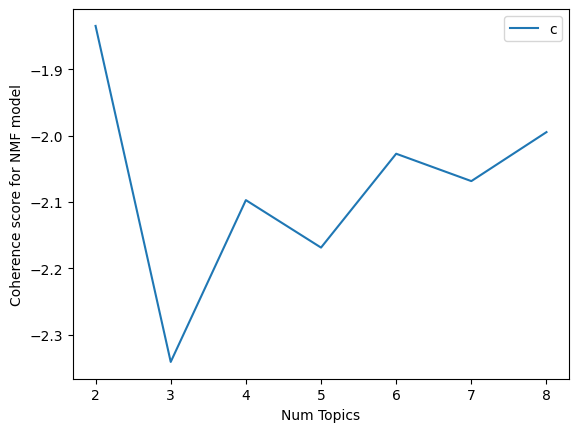

In [12]:
# try to find the best k 
from gensim.models.coherencemodel import CoherenceModel

coherence = []

for k in range(2, 9):
    good_model = Nmf(corpus=corpus, num_topics=k, id2word=dictionary, passes=25) #Number of passes through the corpus during training.
    
    good_cohe = CoherenceModel(model=good_model, corpus=corpus,
                            dictionary=dictionary, coherence='u_mass') #The greater the number, the better is coherence score.
    
    coherence.append(good_cohe.get_coherence())
    
# Show graph
import matplotlib.pyplot as plt

x = range(2,9)
plt.plot(x, coherence)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score for NMF model")
plt.legend(("coherence_values"), loc='best')
plt.show()

## Top2Vec

In [13]:
from top2vec import Top2Vec

2022-11-08 19:30:21.283563: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [14]:
# build the model using Top2Vec
# your text data should a list of string
Top_model = Top2Vec(reviews.values, embedding_model='universal-sentence-encoder') #Top2Vec - the pre-trained universal sentence encoders

2022-11-08 19:31:05,754 - top2vec - INFO - Pre-processing documents for training
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
2022-11-08 19:31:37,064 - top2vec - INFO - Downloading universal-sentence-encoder model
2022-11-08 19:31:37.331696: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-08 19:31:45,886 - top2vec - INFO - Creating joint document/word embedding
INFO:top2vec:Creating joint document/word embedding
2022-11-08 19:32:35,423 - top2vec

In [15]:
# viewing the number of topics
Top_model.get_num_topics()

207

In [16]:
#Getting Keywords for each Topic
Top_model.topic_words[:2]

array([['troma', 'karloff', 'razzie', 'comedies', 'directorial',
        'watchable', 'mockumentary', 'cronenberg', 'slapstick',
        'hellraiser', 'moviegoers', 'horror', 'campy', 'unwatchable',
        'branagh', 'verhoeven', 'schlock', 'overacting', 'movie',
        'oldboy', 'lampoon', 'godard', 'biopic', 'lighthearted',
        'liotta', 'fellini', 'comedy', 'films', 'tomei', 'lugosi',
        'coppola', 'soderbergh', 'uwe', 'dafoe', 'cheesiness',
        'mulholland', 'wayans', 'screenwriters', 'miike', 'film',
        'formulaic', 'phantasm', 'pfeiffer', 'manos', 'miniseries',
        'gilliam', 'viewings', 'coen', 'truffaut', 'screenplay'],
       ['directorial', 'godard', 'fellini', 'biopic', 'watchable',
        'moviegoers', 'cinematography', 'mulholland', 'branagh',
        'oldboy', 'viewings', 'truffaut', 'screenwriters', 'films',
        'filmmaking', 'verhoeven', 'razzie', 'movie', 'mockumentary',
        'film', 'coen', 'troma', 'overacting', 'soderbergh', 'bergman'

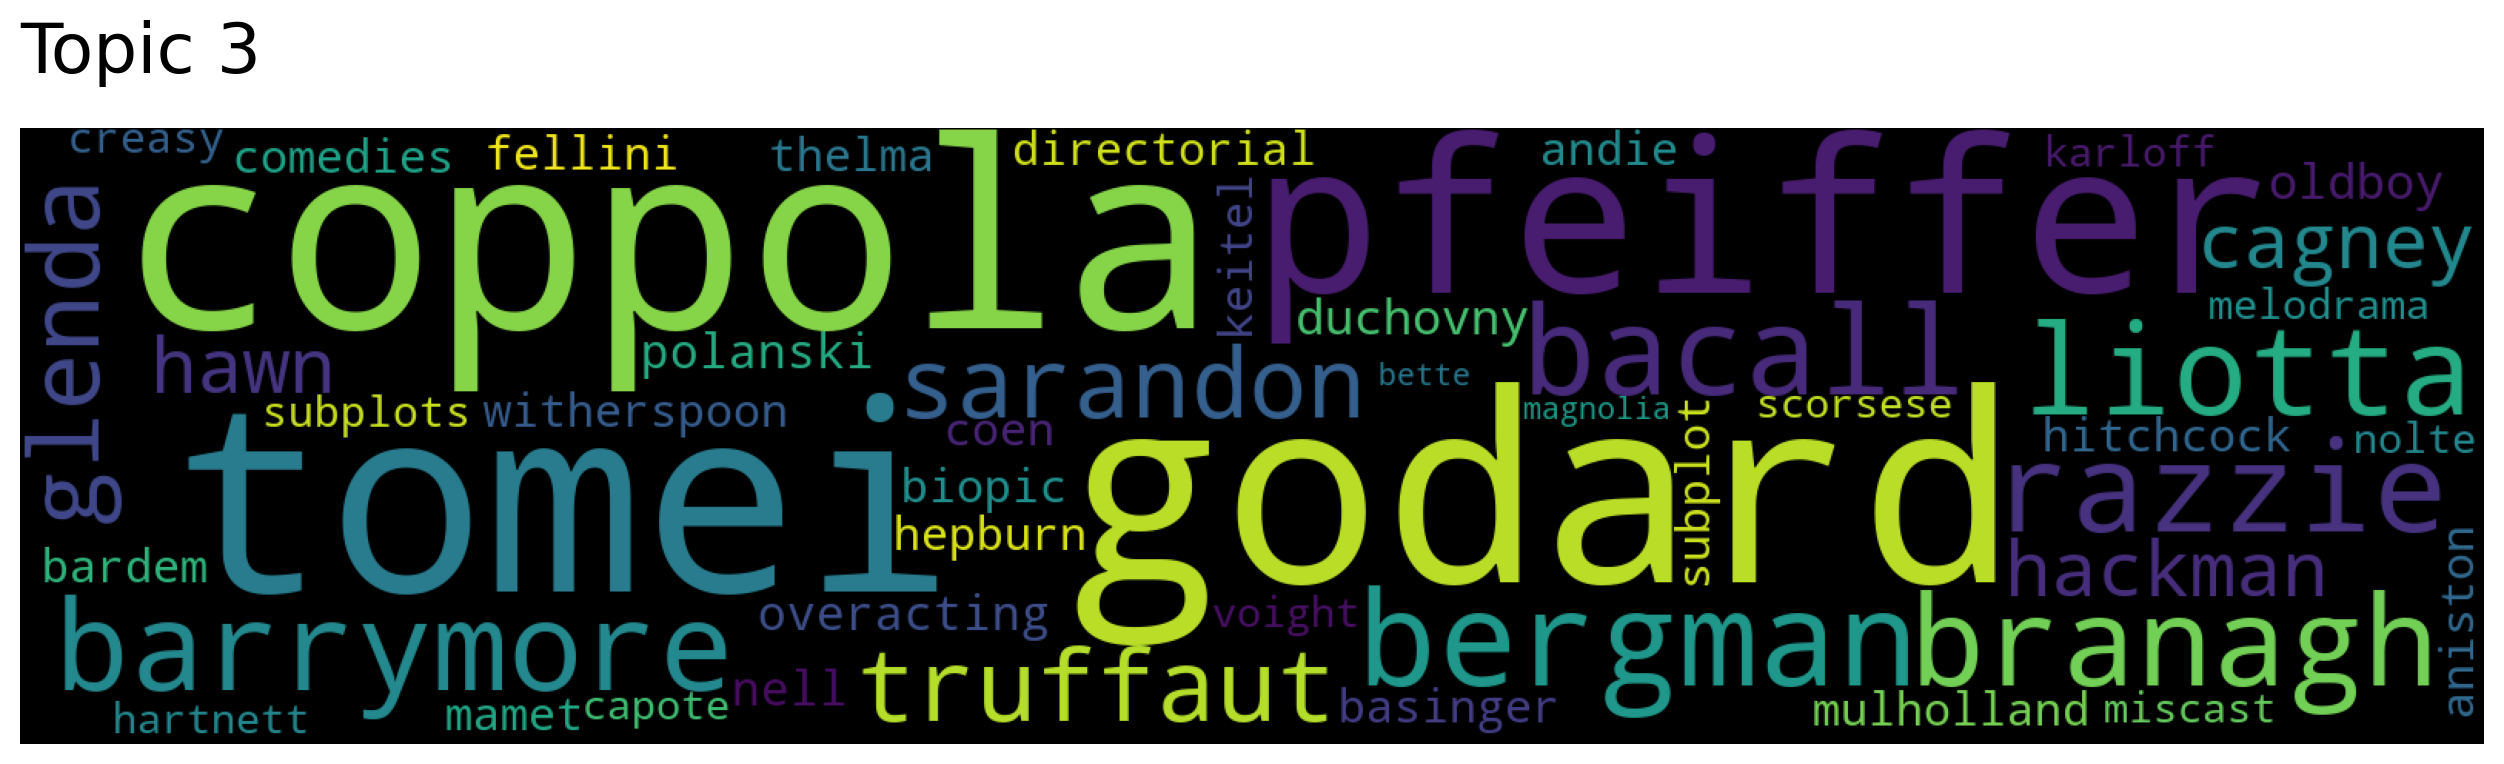

In [17]:
#Creating Topic Word Clouds for topic 4
Top_model.generate_topic_wordcloud(3)

In [18]:
#Searching for Topics Using Keywords
topic_words, word_scores, topic_scores, topic_nums = Top_model.search_topics(keywords=["storm"], num_topics=10)

print(topic_nums)
print(topic_scores)

[183 164  97  56 136 152 103  80  35 196]
[0.18358259 0.17892962 0.17416882 0.16969087 0.15710023 0.15237535
 0.15040124 0.14491058 0.14293666 0.13821353]


In [19]:
# get topic 16
Top_model.topic_words[15]

array(['akshay', 'bollywood', 'amitabh', 'salman', 'bachchan', 'kapoor',
       'razzie', 'oldboy', 'overacting', 'fellini', 'coppola', 'vijay',
       'hackman', 'godard', 'amrita', 'biopic', 'moviegoers',
       'directorial', 'govinda', 'branagh', 'tomei', 'films', 'movie',
       'verhoeven', 'pfeiffer', 'bergman', 'filmmaking', 'liotta',
       'kurosawa', 'actresses', 'cinematography', 'screenwriters',
       'bakshi', 'arquette', 'watchable', 'truffaut', 'fiennes', 'deniro',
       'movies', 'gyllenhaal', 'anand', 'fishburne', 'film', 'bacall',
       'damme', 'bardem', 'soderbergh', 'casablanca', 'filmmaker',
       'comedies'], dtype='<U15')

## BERTopic

In [21]:
import pandas as pd 
import numpy as np
from bertopic import BERTopic

In [22]:
# Build the model with BERTopic
# documentation: https://maartengr.github.io/BERTopic/api/bertopic.html#bertopic._bertopic.BERTopic
BER_model = BERTopic() 

topics, probabilities = BER_model.fit_transform(reviews)

KeyboardInterrupt: 

In [22]:
#Select Top 10 Topics
# in total it returns 32 topics
BER_model.get_topic_freq().head(11)

ValueError: This BERTopic instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

In [ ]:
# visualize your model: intertopic distance map
BER_model.visualize_topics()

In [ ]:
# visualize by terms
BER_model.visualize_barchart()

In [ ]:
# visualize the topic similarty
BER_model.visualize_heatmap()

In [ ]:
# visualize the term scores
newBER_model.visualize_term_rank()